# 1. Gathering Data

The file `twitter-archive-enhanced.csv` has been provided. We will need to download the file image-predictions.tsv and generate a tweet-json.txt connecting to the Twitter API.

In [168]:
import pandas as pd
import numpy as np
import json

In [4]:
# Use the request library to download image_predictions.tsv
import requests

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

with open('./image-predictions.tsv', 'wb') as f:
    f.write(r.content)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

200
text/tab-separated-values; charset=utf-8
utf-8


In [3]:
# Get favorite and retweet count from Twitter API
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

consumer_key = '0xWAMMPntLHa6hUCzpg3YA'
consumer_secret = 'xndZABpG83V60YviIYb2NU6U7SQ4iPkKd8Y9qYt78'
access_token = '13436632-kKtXtLXcWrVyFSa9GZXgAOEljOFZbOdlseVETb00'
access_secret = '7bXeib4JRlvpRb68b8gcaazhxTGf0mXUxqNYJAuII'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive

# Vars
df_1 = pd.read_csv('twitter-archive-enhanced.csv')
tweet_ids = df_1.tweet_id.values
fails_dict = {}
count = 0

start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Once we have all the files downloaded, the next step will be assessing the data looking for Quality and Tidy issues. 

## 1.1 Create one dataframe from each file

In [169]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
df_tweet_json = pd.read_json('tweet-json', lines=True)

# 2. Assess

## 2.1 Assess Twitter Archive Enhanced Dataframe

In [14]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [17]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [33]:
df_twitter_archive.duplicated().sum()

0

In [18]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [27]:
# Check for replies & retweets
print('Number of replies:', df_twitter_archive.in_reply_to_user_id.count())
print('Number of retweets:', df_twitter_archive.retweeted_status_id.count())

Number of replies: 78
Number of retweets: 181


In [38]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [39]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [40]:
df_twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Oliver         11
Cooper         11
Lucy           11
Tucker         10
Lola           10
Penny          10
Bo              9
Winston         9
the             8
Sadie           8
Daisy           7
an              7
Buddy           7
Toby            7
Bailey          7
Koda            6
Dave            6
Rusty           6
Milo            6
Jack            6
Leo             6
Scout           6
Bella           6
Stanley         6
Jax             6
Oscar           6
Louis           5
             ... 
Pubert          1
Jangle          1
Farfle          1
Jaspers         1
Jomathan        1
Tessa           1
Carbon          1
Chesney         1
Hall            1
Kulet           1
Kanu            1
Berb            1
Ester           1
Staniel         1
Sojourner       1
Beckham         1
Skittles        1
Marq            1
Rascal          1
Kellogg         1
Theo            1
Eriq            1
Gustav          1
Ambrose         1
Ziva      

In [15]:
df_twitter_archive.query('name == "a"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None
1207,715733265223708672,NaN,NaN,2016-04-01 02:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a taco. We only rate dogs. Please only...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715733265...,10,10,a,None,None,None,None
1340,704859558691414016,NaN,NaN,2016-03-02 02:43:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a heartbreaking scene of an incredible...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704859558...,10,10,a,None,None,pupper,None


In [16]:
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

## 2.2 Assess Image Predictions Dataframe

In [31]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [19]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [171]:
# There seems to be some inconsistency with the capitalization of the p1, p2 and p3 columns
df_image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     20
Cardigan                      19
web_site                      19
teddy                         18
Eskimo_dog                    18
Shetland_sheepdog             18
beagle                        18
Maltese_dog                   18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [41]:
df_image_predictions.duplicated().sum()

0

In [18]:
# Are there tweets with duplicated images?
df_image_predictions.jpg_url.duplicated().sum()

66

In [20]:
df_image_predictions[df_image_predictions.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


In [21]:
# Check one of these tweets with duplicated image url
df_image_predictions.query('jpg_url == "https://pbs.twimg.com/media/CtVAvX-WIAAcGTf.jpg"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1478,780601303617732608,https://pbs.twimg.com/media/CtVAvX-WIAAcGTf.jpg,1,Saint_Bernard,0.995143,True,Cardigan,0.003044,True,English_springer,0.00105,True
1736,821813639212650496,https://pbs.twimg.com/media/CtVAvX-WIAAcGTf.jpg,1,Saint_Bernard,0.995143,True,Cardigan,0.003044,True,English_springer,0.00105,True


In [22]:
# Check both tweets in the archive dataframe
df_twitter_archive.query('tweet_id == 780601303617732608')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
739,780601303617732608,NaN,NaN,2016-09-27 02:53:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Hercules. He can have whatever he wants f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/780601303...,12,10,Hercules,None,None,None,None


In [23]:
df_twitter_archive.query('tweet_id == 821813639212650496')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
422,821813639212650496,NaN,NaN,2017-01-18 20:16:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Hercules. He can have what...,7.806013e+17,4.196984e+09,2016-09-27 02:53:48 +0000,https://twitter.com/dog_rates/status/780601303...,12,10,Hercules,None,None,None,None


Seems that the duplicated images corresponds with the retweets, that we should clean in the clean step.

In [42]:
df_image_predictions.tweet_id.value_counts()

685532292383666176    1
826598365270007810    1
692158366030913536    1
714606013974974464    1
715696743237730304    1
776477788987613185    1
772114945936949249    1
699775878809702401    1
780858289093574656    1
700462010979500032    1
732726085725589504    1
738883359779196928    1
798644042770751489    1
743510151680958465    1
837012587749474308    1
833722901757046785    1
668620235289837568    1
842765311967449089    1
685315239903100929    1
673686845050527744    1
680473011644985345    1
666051853826850816    1
675853064436391936    1
693231807727280129    1
705475953783398401    1
829449946868879360    1
759923798737051648    1
667160273090932737    1
680934982542561280    1
743545585370791937    1
                     ..
794926597468000259    1
776113305656188928    1
825026590719483904    1
834209720923721728    1
775733305207554048    1
669564461267722241    1
879492040517615616    1
720775346191278080    1
666362758909284353    1
750506206503038976    1
6931556864910008

## 2.3 Assess Tweet Json Dataframe

In [44]:
df_tweet_json

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [21]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [3]:
df_tweet_json.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2354.000000,0.0,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,2211.0,2211.0,2.900000e+01,2.900000e+01,2354.000000
mean,NaN,NaN,8080.968564,NaN,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,0.0,0.0,8.162686e+17,8.162686e+17,3164.797366
std,NaN,NaN,11814.771334,NaN,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,0.0,0.0,6.164161e+16,6.164161e+16,5284.770364
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,0.0,6.721083e+17,6.721083e+17,0.000000
25%,NaN,NaN,1415.000000,NaN,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,0.0,0.0,7.888183e+17,7.888183e+17,624.500000
50%,NaN,NaN,3603.500000,NaN,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.340867e+17,8.340867e+17,1473.500000
75%,NaN,NaN,10122.250000,NaN,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.664587e+17,8.664587e+17,3652.000000
max,NaN,NaN,132810.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,0.0,8.860534e+17,8.860534e+17,79515.000000


In [6]:
# As the max favorite_count diverges a lot from the mean, let´s check if it could be a error
df_tweet_json.favorite_count.sort_values(ascending=False)

# Looking at the results, it doesn´t seem so. There are at least 6 tweets with over 100k favorites

412     132810
1037    131075
65      107956
533     107015
134     106827
448      95450
114      85011
536      75639
168      75193
1077     75163
41       74423
355      73397
76       71144
22       69871
37       68152
1828     67100
153      66437
1764     61794
364      58302
458      57622
7        56848
394      56413
623      55683
122      55098
868      55016
135      54720
53       51522
55       50199
447      49960
552      49774
         ...  
158          0
159          0
596          0
602          0
668          0
194          0
193          0
601          0
924          0
600          0
599          0
184          0
598          0
597          0
181          0
179          0
681          0
595          0
594          0
381          0
593          0
385          0
670          0
676          0
170          0
909          0
588          0
164          0
585          0
484          0
Name: favorite_count, Length: 2354, dtype: int64

In [8]:
# Let´s do the same with retweet count
df_tweet_json.retweet_count.sort_values(ascending=False)

# Again, these results seem normal, so no apparent input/import errors here

1037    79515
533     56625
259     56625
1077    52360
816     52360
412     48265
65      45849
448     42228
445     42228
154     37911
536     37911
164     33421
868     33421
131     32883
134     32883
1828    31989
302     31314
458     31314
1764    30742
623     27728
114     27680
168     25661
117     25661
1623    24514
653     24514
888     24319
1075    24319
449     24069
528     24069
309     24013
        ...  
965        39
883        38
284        38
2335       37
2257       37
2222       34
2258       34
610        32
100        31
408        31
187        27
1235       26
2187       25
211        23
2317       23
178        20
1521       19
185        17
2337       16
2296       14
63         10
426        10
54          7
1078        6
29          4
112         3
341         3
273         3
1293        2
290         0
Name: retweet_count, Length: 2354, dtype: int64

In [14]:
# Check for null values on fav and retweet count
print('Null values in favorite_count?', df_tweet_json.favorite_count.isnull().any())
print('Null values in retweet_count?', df_tweet_json.retweet_count.isnull().any())
print('Null values in user?', df_tweet_json.user.isnull().any())

Null values in favorite_count? False
Null values in retweet_count? False
Null values in user? False


## 2.4 Issues 

### Quality issues assesed

1. `tweet_id` is an integer but it should be a string as it is not used to compute anything
2. `timestamp` column should have datetime format
3. There are replies and retweets in our data
4. There are tweets without images
5. `name` column contains strings that aren´t names as 'a', 'an', 'the'...
6. `source` column contains html code
7. `p1`, `p2`, `p3` columns have inconsistent capitalization
8. There are too many unneded columns

### Tidyness

1. One of the rules of Tiny Data is that each variable forms a column. In this dataframe we have one variable `dog_stages` split in 4 columns `doggo`, `floofer`, `pupper`, `puppo`.
2. Another rule about Tiny Data is that each type of obserbational unit forms a table. We are analyzing tweets, but we have the information split in three different dataframes. We should combine them.

# 3 Clean

In [150]:
# Let´s creat copies of our dataframes
df2_twitter_archive = df_twitter_archive.copy()
df2_image_predictions = df_image_predictions.copy()
df2_tweet_json = df_tweet_json.copy()

## 3.1Tidyness issues

Let´s with the tidyness issues detected in our assessment phase. To solve the detected problem we will do the next actions:

1. Create one dog_stage column from 4 different ones
2. Combine DataFrames

### 3.1.1 Create one dog_stage column from 4 different ones

In [151]:
# Create one column for the dog_stage variable

# To ease the creation of the column we will first clean the quality issue about having the string None
list = ['doggo', 'floofer', 'pupper', 'puppo']
for _ in list:
    df2_twitter_archive[_].replace(to_replace=['None'], value='', inplace=True)

# Create the new column
df2_twitter_archive['dog_stage'] = df2_twitter_archive[['doggo', 'floofer', 'pupper', 'puppo']].apply(lambda x: ''.join(x), axis=1)  

# Fill empty strings to None
df2_twitter_archive.dog_stage.replace(to_replace=[''], value='None', inplace=True)

# Delete old columns
df2_twitter_archive.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

df2_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


### 3.1.2 Combine DataFrames

In [152]:
# First, the json dataframe contains a lot of columns we are not interested in. 
# Let´s create another one keeping only the columns we are interested in.
df2_tweet_json = df2_tweet_json[['id', 'favorite_count', 'retweet_count']]

# Rename id column to tweet_id to ease the later merge
df2_tweet_json.rename(columns={'id' : 'tweet_id'}, inplace=True)

df2_tweet_json.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


In [153]:
# Merge all dataframes so we have all the information related to a tweet in the same one 
aux = pd.merge(df2_twitter_archive, 
                 df2_tweet_json,
                 left_on='tweet_id',
                 right_on='tweet_id',
                 how='left')

df_merged_dataframes = pd.merge(aux,
                               df2_image_predictions,
                               left_on='tweet_id',
                               right_on='tweet_id',
                               how='left')

df_merged_dataframes.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [154]:
df_merged_dataframes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     2356 non-null object
favorite_count                2354 non-null float64
retweet_count                 2354 non-null float64
jpg_url                       2075 non-null object
img_num                       

## 3.2 Quality Issues

Next, we´ll fix the quality issues raised during our assessment with the following actions:

1. Convert tweet_id from integer to string
2. Apply datetime format to timestamp column
3. Delete replies and retweets
4. Delete tweets without image
5. Fix wrong names
6. Strip html tags from source column
7. Fix inconsistent capitalization in p1, p2, p3 colums
8. Delete unneded columns

### 3.2.1 Convert tweet_id from integer to string

In [155]:
df_merged_dataframes.tweet_id = df_merged_dataframes.tweet_id.astype(str)
df_merged_dataframes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     2356 non-null object
favorite_count                2354 non-null float64
retweet_count                 2354 non-null float64
jpg_url                       2075 non-null object
img_num                      

### 3.2.2 Apply datetime format to timestamp column

In [156]:
df_merged_dataframes.timestamp = pd.to_datetime(df_merged_dataframes.timestamp)
df_merged_dataframes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     2356 non-null object
favorite_count                2354 non-null float64
retweet_count                 2354 non-null float64
jpg_url                       2075 non-null object
img_num              

### 3.2.3 Delete replies and retweets

In [157]:
# Delete tweets that are replies from the dataframe
df_merged_dataframes = df_merged_dataframes[df_merged_dataframes.in_reply_to_status_id.isnull()] 

# Delete tweets that are retweets from the dataframe
df_merged_dataframes = df_merged_dataframes[df_merged_dataframes.retweeted_status_id.isnull()] # 181 results

# Check for replies & retweets
print('Number of replies:', df_merged_dataframes.in_reply_to_user_id.count())
print('Number of retweets:', df_merged_dataframes.retweeted_status_id.count())

Number of replies: 0
Number of retweets: 0


### 3.2.4 Delete tweets without image

In [158]:
df_merged_dataframes = df_merged_dataframes[df_merged_dataframes.jpg_url.notnull()]
df_merged_dataframes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      1971 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1971 non-null datetime64[ns]
source                        1971 non-null object
text                          1971 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1971 non-null object
rating_numerator              1971 non-null int64
rating_denominator            1971 non-null int64
name                          1971 non-null object
dog_stage                     1971 non-null object
favorite_count                1971 non-null float64
retweet_count                 1971 non-null float64
jpg_url                       1971 non-null object
img_num                      

In [159]:
df_merged_dataframes.describe()

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,0.0,0.0,0.0,0.0,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1.971000e+03,1.971000e+03
mean,NaN,NaN,NaN,NaN,12.223237,10.477423,8949.106545,2784.449518,1.201928,0.594558,1.345850e-01,6.016556e-02
std,NaN,NaN,NaN,NaN,41.634034,6.853275,12267.799790,4697.662893,0.559020,0.272126,1.010527e-01,5.094156e-02
min,NaN,NaN,NaN,NaN,0.000000,2.000000,81.000000,16.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,NaN,NaN,NaN,NaN,10.000000,10.000000,1997.000000,628.500000,1.000000,0.363091,5.339800e-02,1.608055e-02
50%,NaN,NaN,NaN,NaN,11.000000,10.000000,4147.000000,1367.000000,1.000000,0.587764,1.173970e-01,4.944380e-02
75%,NaN,NaN,NaN,NaN,12.000000,10.000000,11402.500000,3239.000000,1.000000,0.847827,1.955655e-01,9.153815e-02
max,NaN,NaN,NaN,NaN,1776.000000,170.000000,132810.000000,79515.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


### 3.2.5 Fix wrong names

In [160]:
# There are names that are not names as 'a', 'an', 'the' that seem clear input errors.
# Let´s clean them converting all lowercase word to 'None'

df_merged_dataframes.name = df_merged_dataframes.name.mask(df_aux.name.str.match(r'^[a-z]+$'), 'None')
df_merged_dataframes.name.value_counts()

None        622
Charlie      11
Oliver       10
Lucy         10
Cooper       10
Tucker        9
Penny         9
Sadie         8
Winston       8
Daisy         7
Lola          7
Toby          7
Bo            6
Jax           6
Koda          6
Bella         6
Stanley       6
Dave          5
Bailey        5
Oscar         5
Louis         5
Milo          5
Buddy         5
Scout         5
Leo           5
Rusty         5
Chester       5
Alfie         4
Reggie        4
Jack          4
           ... 
Andru         1
Duddles       1
Geno          1
Stormy        1
Pepper        1
Brutus        1
Tayzie        1
Fwed          1
Zeek          1
Dietrich      1
Luther        1
Nico          1
Jazzy         1
Jiminus       1
Strider       1
Rodman        1
Ike           1
Remy          1
Kona          1
Rose          1
Philippe      1
Farfle        1
JD            1
Jersey        1
Eleanor       1
Sparky        1
Jessiga       1
Jaycob        1
Travis        1
Ambrose       1
Name: name, Length: 913,

In [161]:
df_merged_dataframes.sample(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1733,679777920601223168,NaN,NaN,2015-12-23 21:37:40,"<a href=""http://twitter.com/download/iphone"" r...",This is Rinna. She's melting. 10/10 get inside...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679777920...,...,1.0,bloodhound,0.528819,True,bull_mastiff,0.420119,True,French_bulldog,9.480590e-03,True
1805,676942428000112642,NaN,NaN,2015-12-16 01:50:26,"<a href=""http://twitter.com/download/iphone"" r...",Who leaves the last cupcake just sitting there...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676942428...,...,1.0,black-footed_ferret,0.707199,False,polecat,0.154630,False,weasel,9.762550e-02,False
2226,668274247790391296,NaN,NaN,2015-11-22 03:46:11,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sophie. Her son just got in the car to le...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668274247...,...,1.0,soft-coated_wheaten_terrier,0.406374,True,Lakeland_terrier,0.263854,True,toy_poodle,1.508440e-01,True
940,753026973505581056,NaN,NaN,2016-07-13 00:43:15,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Tayzie. She's a Barbadian Bugaboo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/753026973...,...,3.0,Pembroke,0.868511,True,Cardigan,0.103708,True,Shetland_sheepdog,1.814160e-02,True
1632,684460069371654144,NaN,NaN,2016-01-05 19:42:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeph. He's a Western Sagittarius Dookm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684460069...,...,1.0,Labrador_retriever,0.673691,True,Chesapeake_Bay_retriever,0.194897,True,American_Staffordshire_terrier,5.947130e-02,True
632,793962221541933056,NaN,NaN,2016-11-02 23:45:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Maximus. His face is stuck like that. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793962221...,...,1.0,Labrador_retriever,0.861651,True,golden_retriever,0.044462,True,Staffordshire_bullterrier,1.649670e-02,True
1489,692905862751522816,NaN,NaN,2016-01-29 03:03:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Wally. He's being abducted by aliens. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692905862...,...,1.0,Mexican_hairless,0.162638,True,Doberman,0.156287,True,Rhodesian_ridgeback,8.147780e-02,True
451,818627210458333184,NaN,NaN,2017-01-10 01:15:10,"<a href=""http://twitter.com/download/iphone"" r...",Meet Wafer. He represents every fiber of my be...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/818627210...,...,1.0,Labrador_retriever,0.384188,True,beagle,0.255917,True,grocery_store,7.979950e-02,False
1240,712085617388212225,NaN,NaN,2016-03-22 01:16:55,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Olive and Ruby. They are best bud...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712085617...,...,2.0,Shih-Tzu,0.625129,True,Tibetan_terrier,0.126897,True,Lhasa,1.196630e-01,True
89,875021211251597312,NaN,NaN,2017-06-14 16:04:48,"<a href=""http://twitter.com/download/iphone"" r...",Guys please stop sending pictures without any ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/875021211...,...,2.0,West_Highland_white_terrier,0.714319,True,Siberian_husky,0.091913,True,Great_Pyrenees,4.603820e-02,True


### 3.2.6 Strip html tags from source column

In [162]:
import re
df_merged_dataframes.source = df_merged_dataframes.source.apply(lambda x: re.sub('<[^<]+?>', '', x))
df_merged_dataframes.source.value_counts()


Twitter for iPhone    1932
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

### 3.2.7 Fix inconsistent capitalization in p1, p2, p3 colums

In [163]:
for _ in ['p1', 'p2', 'p3']:
  df_merged_dataframes[_] = df_merged_dataframes[_].str.lower()
df_merged_dataframes

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,1.0,chesapeake_bay_retriever,0.425595,True,irish_terrier,0.116317,True,indian_elephant,0.076902,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,1.0,appenzeller,0.341703,True,border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,2.0,pomeranian,0.566142,True,eskimo_dog,0.178406,True,pembroke,0.076507,True
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,1.0,irish_terrier,0.487574,True,irish_setter,0.193054,True,chesapeake_bay_retriever,0.118184,True
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,1.0,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True


### 3.2.8 Delete unneded columns

In [164]:
df_merged_dataframes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      1971 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1971 non-null datetime64[ns]
source                        1971 non-null object
text                          1971 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1971 non-null object
rating_numerator              1971 non-null int64
rating_denominator            1971 non-null int64
name                          1971 non-null object
dog_stage                     1971 non-null object
favorite_count                1971 non-null float64
retweet_count                 1971 non-null float64
jpg_url                       1971 non-null object
img_num                      

In [165]:
# Drop unneded columns
df_merged_dataframes.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', \
                                   'retweeted_status_id', 'retweeted_status_user_id',\
                                   'retweeted_status_timestamp'], inplace=True)

In [167]:
df_merged_dataframes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             1971 non-null object
favorite_count        1971 non-null float64
retweet_count         1971 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               

In [229]:
# Store the dataframe
df_merged_dataframes.to_csv('twitter_archive_master.csv')

## 4 Analysis

Which are the most retweeted / favorited dogs? Also by rating.

— What are the most popular breeds?

— Is there any correlation between rating and popularity

Which are the most favorited / retweeted users?

Which are the most popular categories? Doggo, puppy…


### 4.1 Let´s see the most favorited dogs

No very useful, but after so many work with the data I´m curious about how look the most popular dogs.

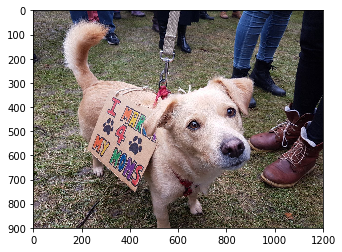

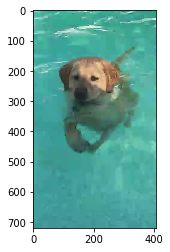

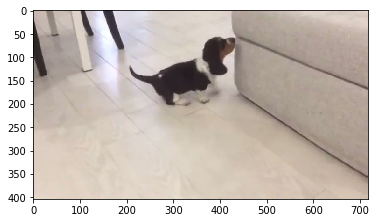

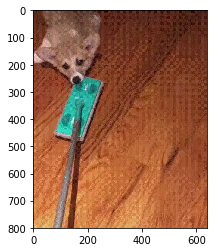

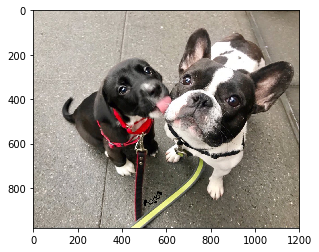

In [205]:
top5_favorited_dogs = df_merged_dataframes.sort_values(by='favorite_count', ascending=False).head(5).jpg_url

from PIL import Image
import requests
import matplotlib.pyplot as plt

for dog_url in top5_favorited_dogs:
    response = requests.get(dog_url, stream=True)
    img = Image.open(response.raw)
    plt.imshow(img)
    plt.show()

### 4.2 Let´s see the most retweeted dogs

Again, not very useful. Our expectation is to see some of the most favorited dogs also in this short list. 

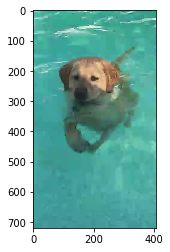

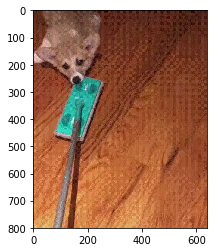

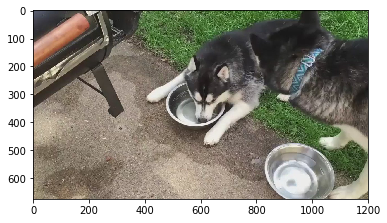

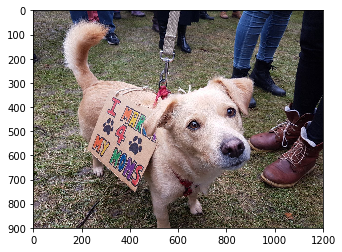

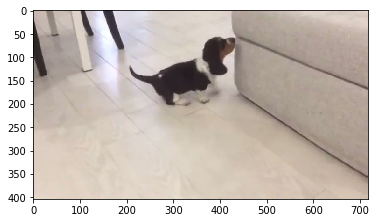

In [206]:
top5_retweeted_dogs = df_merged_dataframes.sort_values(by='retweet_count', ascending=False).head(5).jpg_url

from PIL import Image
import requests
import matplotlib.pyplot as plt

for dog_url in top5_retweeted_dogs:
    response = requests.get(dog_url, stream=True)
    img = Image.open(response.raw)
    plt.imshow(img)
    plt.show()

### 4.3 Is there any correlation between favorite_count and retweet_count?

As we´ve seen with our top 5, we expect that the correlation will be positive between both characteristics. 

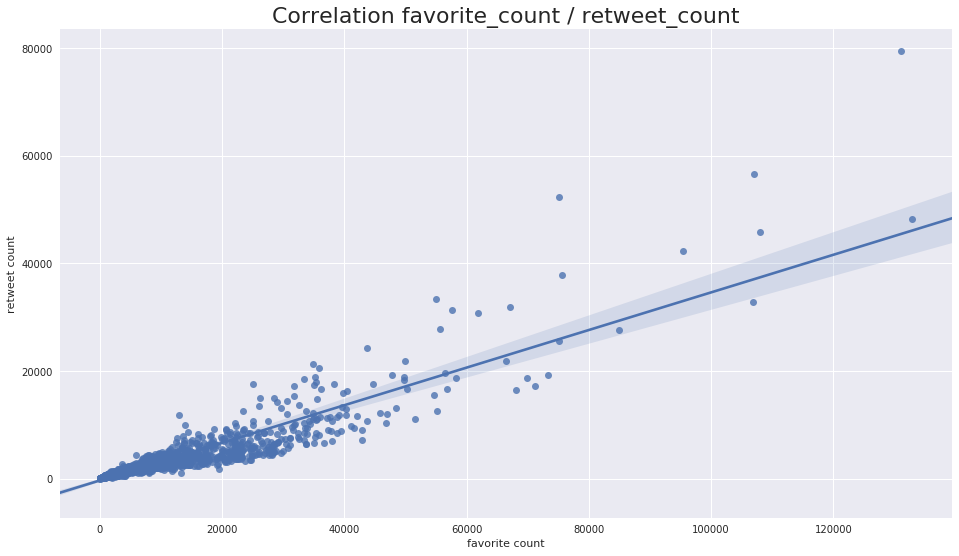

In [216]:
import seaborn as sns

# Variables
chart_title="Correlation favorite_count / retweet_count"
chart_xlabel="favorite count"
chart_ylabel="retweet count"

# Plot
ax = plt.subplots(figsize=(16,9))
ax = sns.regplot(x=df_merged_dataframes['favorite_count'], y=df_merged_dataframes['retweet_count'])

# Function that we will use during the exercise to decorate our charts
# This function was creatd in the first module of the Data Analyst Nanodegree
def decorate(title, xlabel, ylabel, xticks=None, xticklabels=None, yticks=None, yticklabels=None):
    ax.set_title(title, fontsize=22)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)  
    if xticks is not None:
        ax.set_xticks(xticks)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=70)
    if yticks is not None:
        ax.set_xticks(yticks)
    if yticklabels is not None:
        ax.set_xticklabels(yticklabels, rotation=70)
    ax.grid(alpha=1)
    sns.set(style="dark")

# Decorate
decorate(chart_title, chart_xlabel, chart_ylabel)

plt.show;

As we were expecting, the correlation between favorite_count and retweet_count is positive.

### 4.4 Which is the most favorited dog breed?

In [224]:
df_merged_dataframes.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,39467.0,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


In [228]:
df_aux = df_merged_dataframes.copy()
df_aux['breed'] = df_aux.query('p1_dog == True')

#df_merged_dataframes.query('p1_dog == True').p1.value_counts()

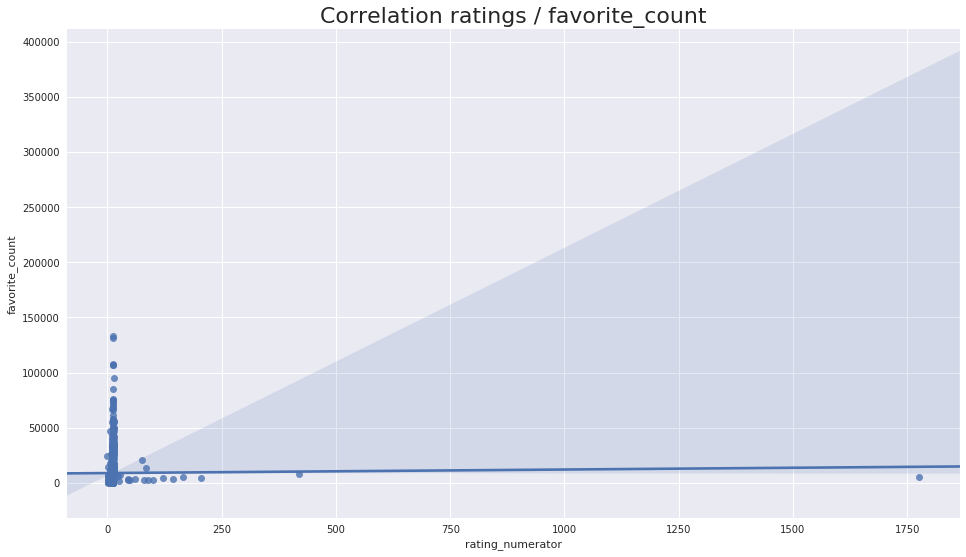

In [221]:
# Variables
chart_title="Correlation ratings / favorite_count"
chart_xlabel="rating_numerator"
chart_ylabel="favorite_count"

# Plot
ax = plt.subplots(figsize=(16,9))
ax = sns.regplot(x=df_merged_dataframes['rating_numerator'], y=df_merged_dataframes['favorite_count'])

# Decorate
decorate(chart_title, chart_xlabel, chart_ylabel)

plt.show;